# Tutorial 2: Implementing perils in the GenMR digital template


**Author:** Arnaud Mignan, Mignan Risk Analytics GmbH  
**Version:** 0.1  
**Last Updated:** 2025-11-03   
**License:** AGPL-3, https://opensource.org/license/agpl-v3 

Once a virtual environment has been generated (see previous tutorial), stochastic events can be modelled to populate it. Table 1 lists the perils so far considered in version 1.1.1 as well as the ones to be added in the near future (v. 1.1.2).

<br>
<center><small><b>Tab. 1.</b> List of perils with identifiers (ID) according to <a href='https://www.cambridge.org/highereducation/books/introduction-to-catastrophe-risk-modelling/A3A5B5FB990921422BFEBB07734BF869#overview' target='_blank'>Mignan (2024:tab.1.7)</a>.</small></center>

| ID | Peril | Peril type | Source class | Event size | Intensity class | Intensity measure | Status<sup>&#8224;</sup> |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
|  | **NATURAL** |  |  |  |  |  |  |
| `AI` | Asteroid impact | Primary | Point | Kinetic energy (kt) | Analytical | Overpressure (kPa) | <span style="color: green">&#x2713;<span> |
| `Dr` | Drought |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `EQ` | Earthquake | Primary | Line | Magnitude | Analytical | Peak ground acceleration (m/s$^2$) | <span style="color: green">&#x2713;<span> |
| `FF` | Fluvial flood | Secondary (to `RS`) | Point | Peak flow | Cellular automaton | Inundation depth (m) | <span style="color: green">&#x2713;<span> |
| `HW` | Heatwave |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `Li` | Lightning |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `LS` | Landslide | Secondary (to `RS`) | Diffuse | Area (km$^2$) | Cellular automaton | Thickness (m) | <span style="color: green">&#x2713;<span> |
| `PI` | Pest infestation |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `RS` | Rainstorm | Primary (invisible$^*$) | Area | Rain intensity (mm/hr) | Threshold | - | <span style="color: green">&#x2713;<span> |
| `SS` | Storm surge | Secondary (to `WS`) | Line | Coastal surge height (m) | Threshold | Inundation depth (m) | <span style="color: green">&#x2713;<span> |
| `TC` | Tropical cyclone | Primary | Track | Max. wind speed (m/s) | Analytical | Max. wind speed (m/s) | <span style="color: green">&#x2713;<span> |
| `To` | Tornado |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `VE` | Volcanic eruption | Primary | Point | Volume erupted (km$^3$) | Analytical | Ash load (kPa) | <span style="color: green">&#x2713;<span> |
| `WF` | Wildfire | Primary | Diffuse | Burnt area | Cellular automaton | Burnt/not burnt | <span style="color: green">&#x2713;<span> |
| `WS` | Windstorm |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
|  | **TECHNOLOGICAL** |  |  |  |  |  |  |
| `BO` | Blackout |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `Ex` | Explosion (industrial) | Primary | Point | TNT mass (kt) | Analytical | Overpressure $P$ (kPa) | <span style="color: green">&#x2713;<span> |
|  | **SOCIO-ECONOMIC** |  |  |  |  |  |  |
| `BI` | Business interruption |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `Sf` | Public service failure |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |
| `SU` | Social unrest |  |  |  |  |  | <span style="color: orange">&#x2717;<span> |

<small>$^*$ Rainstorm is called an 'invisible peril' (following <a href='https://link.springer.com/article/10.1007/s11069-014-1178-4' target='_blank'>Mignan et al., 2014</a>) since it does not cause any direct damage in the present framework. It is implemented as both the landslide and fluvial flood triggering mechanism.<br>
               <sup>&#8224;</sup> To be included in current version 1.1.1 (<span style="color: green">&#x2713;</span>), planned for v.1.1.2 (<span style="color: orange">&#x2717;</span>).</small>


ADD TEXT

Figure 1 illustrates the relationship between some stochastic event footprints and the underlying environment:

<br>

```{figure} ../figures/digitaltemplate_ev_rayshader.png
:name: fig-digitaltemplate
:width: 600px
:align: center

**Fig. 1.** One instance of the GenMR digital template (default parameterisation) with an example of event hazard intensity footprint and loss footprint (here for a large earthquake). Simulation rendered using [Rayshader](https://www.rayshader.com/) (Morgan-Wall, 2022).

/Users/arnaudmignan/Documents/GmbH_MRA/2_fundedR&D/2025-2027_GenMR_SCOR/GenMR_SCOR/GenMR/environment.py:605: RuntimeWarning: divide by zero encountered in divide
  FS = (par['Ceff_Pa'] / (par['rho_kg/m3'] * GenMR_utils.g_earth * h) + np.cos(slope * np.pi/180) * \


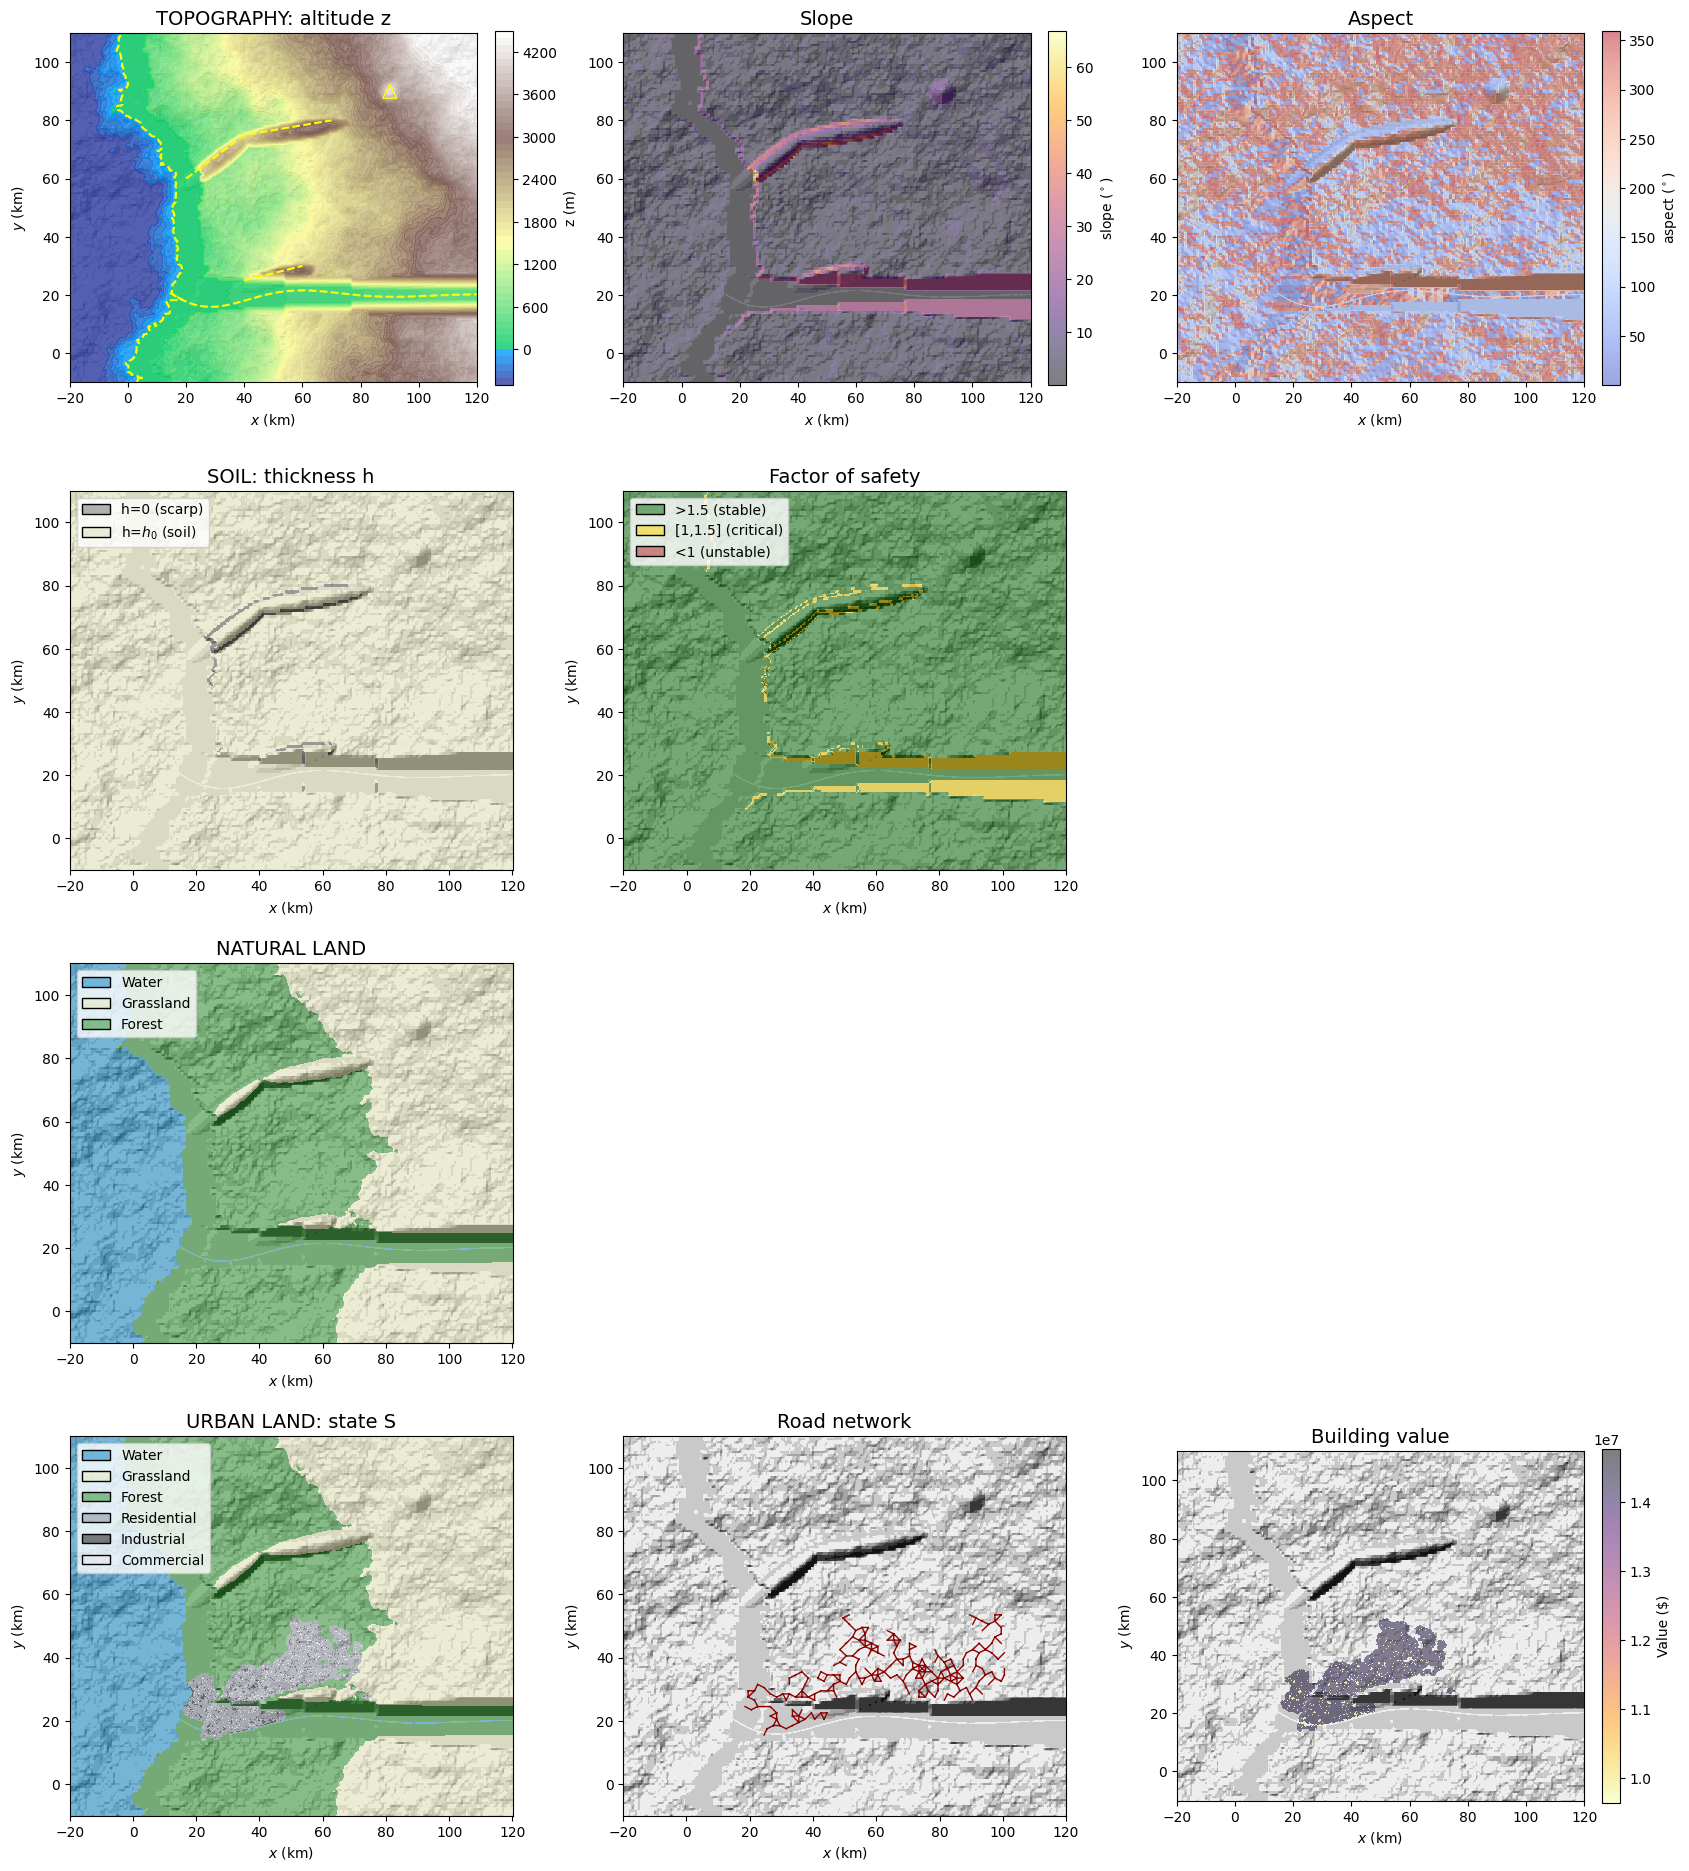

In [7]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

#import warnings 
#warnings.filterwarnings('ignore')   # commented, try to remove all warnings

from GenMR import environment as GenMR_env
from GenMR import utils as GenMR_utils


# load inputs (i.e., outputs from Tutorial 1)
file_src = 'src.pkl'
file_topoLayer = 'envLayer_topo.pkl'
file_soilLayer = 'envLayer_soil.pkl'
file_natLandLayer = 'envLayer_natLand.pkl'
file_urbLandLayer = 'envLayer_urbLand.pkl'
src = GenMR_utils.load_pickle2class('/io/' + file_src)
grid = copy.copy(src.grid)
topoLayer = GenMR_utils.load_pickle2class('/io/' + file_topoLayer)
soilLayer = GenMR_utils.load_pickle2class('/io/' + file_soilLayer)
natLandLayer = GenMR_utils.load_pickle2class('/io/' + file_natLandLayer)
urbLandLayer = GenMR_utils.load_pickle2class('/io/' + file_urbLandLayer)

GenMR_env.plot_EnvLayers([topoLayer, soilLayer, natLandLayer, urbLandLayer], file_ext = 'jpg')

Note that the configuration of the digital template environment may be changed through Tutorial 1.

## 1. Event set definition

### 1.1. Peril source definition

TO DEVELOP